In [2]:
from IPython.display import Image, SVG
import matplotlib.pyplot as plt

import numpy as np
import keras
from keras.datasets import mnist
from keras.models import Model, Sequential, load_model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling1D, ZeroPadding1D, Flatten, Reshape, Conv1D, BatchNormalization, Activation
from keras import regularizers
from sklearn.model_selection import train_test_split

import torch
from torch.utils import data

from magnet.src.data_reader.dataset import TotalMagnetDataset
from magnet.src.model.model import CDCK2

In [3]:
q001_data_raw = np.load('/data1/ryan/train-files/train_q001_bot.npy')
q003_data_raw = np.load('/data1/ryan/train-files/train_q003_bot.npy')
q076_data_raw = np.load('/data1/ryan/train-files/train_q076_bot.npy')
q103_data_raw = np.load('/data1/ryan/train-files/train_q103_bot.npy')

#don't normalize over the whole quench, normalize each image
q001_data = np.zeros_like(q001_data_raw)
q003_data = np.zeros_like(q003_data_raw)
q076_data = np.zeros_like(q076_data_raw)
q103_data = np.zeros_like(q103_data_raw)

q001_max = np.max(q001_data_raw[:,:])
q003_max = np.max(q003_data_raw[:,:])
q076_max = np.max(q076_data_raw[:,:])
q103_max = np.max(q103_data_raw[:,:])

#it's not pretty but it works
for i, im in enumerate(q001_data_raw):
    q001_data[i,:] = q001_data_raw[i,:] / q001_max

for i, im in enumerate(q003_data_raw):
    q003_data[i,:] = q003_data_raw[i,:] / q001_max
    
for i, im in enumerate(q076_data_raw):
    q076_data[i,:] = q076_data_raw[i,:] / q001_max
    
for i, im in enumerate(q103_data_raw):
    q103_data[i,:] = q103_data_raw[i,:] / q001_max

In [4]:
qall_data = np.concatenate((q001_data, q003_data, q076_data, q103_data), axis=0)
print(qall_data.shape)
data_mod = np.empty((qall_data.shape[0], qall_data.shape[1], 1))
data_mod[:, :, 0] = qall_data

x_train_temp, x_test_temp = train_test_split(qall_data, random_state=42)
print(x_train_temp.shape)
print(x_test_temp.shape)

x_train = np.empty((x_train_temp.shape[0], x_train_temp.shape[1], 1))
x_test = np.empty((x_test_temp.shape[0], x_test_temp.shape[1], 1))
x_train[:, :, 0] = x_train_temp
x_test[:, :, 0] = x_test_temp

print(x_train.shape)
print(x_test.shape)

(22820, 2000)
(17115, 2000)
(5705, 2000)
(17115, 2000, 1)
(5705, 2000, 1)


In [5]:
batch = 64
timestep = 12
audio_window = 2000

In [6]:
model = CDCK2(timestep, batch, audio_window).to('cuda')
model.load_state_dict(torch.load('/data1/ryan/snapshot/cdc/cdc-2019-11-04_12_13_11-model_best.pth')['state_dict'])
model.eval()

CDCK2(
  (encoder): Sequential(
    (0): Conv1d(1, 512, kernel_size=(10,), stride=(5,), padding=(3,), bias=False)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv1d(512, 512, kernel_size=(8,), stride=(5,), padding=(2,), bias=False)
    (4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv1d(512, 512, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (7): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): Conv1d(512, 512, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
    (10): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): Conv1d(512, 512, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
    (13): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_

In [7]:
total_set = TotalMagnetDataset('', '', audio_window)
params = {'num_workers': 0,
          'pin_memory': False}
final_loader = data.DataLoader(total_set, batch_size=batch, shuffle=False, **params)

In [8]:
encoded_all = []

for batch_idx, ex in enumerate(final_loader):
    ex = ex.float().unsqueeze(1).to('cuda')  # add channel dimension
    hidden = model.init_hidden(len(ex), use_gpu=True)
    result = model.encoder(ex)
    encoded_all += result.tolist()

encoded_all = np.array(encoded_all)
print(encoded_all.shape)

(22820, 512, 40)


In [9]:
#Try pca on encoded images to cluster the CPC embedded space
from sklearn.decomposition import PCA

encoded = encoded_all[:, 384, :]
print(encoded.shape)

pca = PCA(n_components=2)
#need to flatten i guess?
img_pca = pca.fit_transform(encoded)

#boundary 1
boundary1 = q001_data.shape[0]
#boundary 2
boundary2 = boundary1 + q003_data.shape[0]
#boundary 3
boundary3 = boundary2 + q076_data.shape[0]

color_key=['red','orange','green','blue']
color_label=[]
for i in range(qall_data.shape[0]):
    if i <= boundary1:
        color_label.append(color_key[0])
    elif boundary1 <= i < boundary2:
        color_label.append(color_key[1])
    elif boundary2 <= i < boundary3: 
        color_label.append(color_key[2])
    else:
        color_label.append(color_key[3])
        
print(len(color_label))

(22820, 40)
22820


In [10]:
# See how much variance they take
print('The first component:', pca.explained_variance_ratio_[0])
print('The second component:', pca.explained_variance_ratio_[1])
print('They in fact take much of the variance!')

The first component: 0.7636786443353103
The second component: 0.04101243680278843
They in fact take much of the variance!


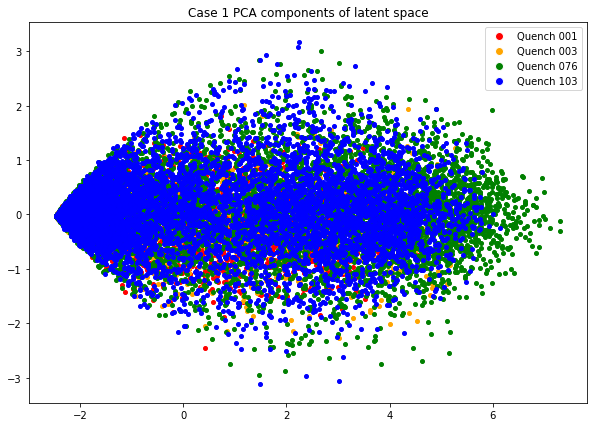

In [11]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

msize = 16

# hack the legend together
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Quench 001',
                          markerfacecolor='red', markersize=8),
                   Line2D([0], [0], marker='o', color='w', label='Quench 003',
                          markerfacecolor='orange', markersize=8),
                   Line2D([0], [0], marker='o', color='w', label='Quench 076',
                          markerfacecolor='green', markersize=8),
                   Line2D([0], [0], marker='o', color='w', label='Quench 103',
                          markerfacecolor='blue', markersize=8)]

# Create the figure and add our hacked legend
plt.figure(figsize=(10, 7))
for i in range(qall_data.shape[0]):
    plt.scatter(img_pca[i,0],img_pca[i,1], s=msize, color=color_label[i])
plt.title('Case 1 PCA components of latent space')
plt.legend(handles=legend_elements)
plt.show()

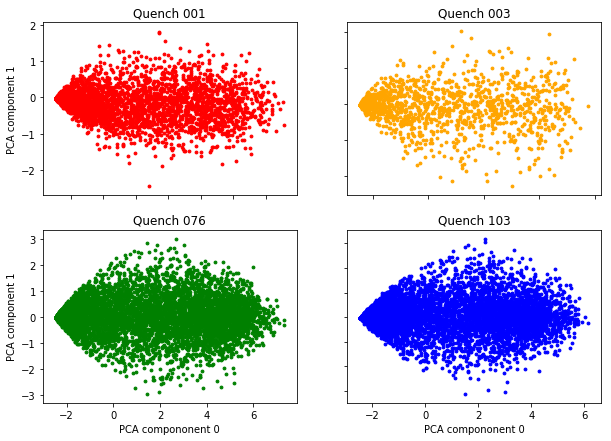

In [12]:
msize = 8

fig, axs = plt.subplots(2, 2)
fig.set_size_inches(10,7)
for i in range(qall_data.shape[0]):
    if color_label[i] == 'red':
        axs[0, 0].scatter(img_pca[i,0],img_pca[i,1], color=color_label[i], s=msize)
        axs[0, 0].set_title('Quench 001')
    elif color_label[i] == 'orange':
        axs[0, 1].scatter(img_pca[i,0],img_pca[i,1], color=color_label[i], s=msize)
        axs[0, 1].set_title('Quench 003')
    elif color_label[i] == 'green':
        axs[1, 0].scatter(img_pca[i,0],img_pca[i,1], color=color_label[i], s=msize)
        axs[1, 0].set_title('Quench 076')
    else:
        axs[1, 1].scatter(img_pca[i,0],img_pca[i,1], color=color_label[i], s=msize)
        axs[1, 1].set_title('Quench 103')

for ax in axs.flat:
    ax.set(xlabel='PCA compononent 0', ylabel='PCA component 1')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

In [23]:
# Finally, try using DBSCAN to directly cluster high-dimensional data!
from sklearn.cluster import DBSCAN
print(encoded.shape)

clustering = DBSCAN(eps=0.1).fit(encoded)
print(clustering.labels_)

(22820, 40)
[ 0  0  0 ... -1 -1 -1]


In [19]:
from hdbscan import HDBSCAN

clustering = HDBSCAN().fit(encoded)
print(clustering.labels_)

[53 -1 53 ... -1 -1 -1]


In [14]:
number_of_minus = 0
number_of_zeros = 0
number_of_thirtyones = 0

for i in range(len(encoded)):
    if clustering.labels_[i] == -1:
        number_of_minus += 1
    elif clustering.labels_[i] == 0:
        number_of_zeros += 1
    elif clustering.labels_[i] == 31:
        number_of_thirtyones += 1

print(number_of_minus + number_of_zeros + number_of_thirtyones)
print(number_of_minus)
print(number_of_zeros)
print(number_of_thirtyones)
# print(clustering.labels_.tolist())

22820
18266
4554
0


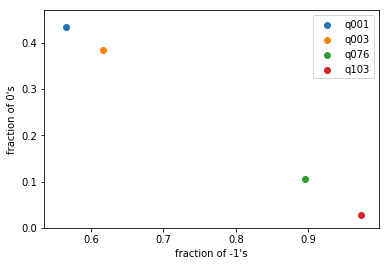

In [15]:
# Interesting results!

q001_minus = 0
q001_31 = 0
q003_minus = 0
q003_31 = 0
q076_minus = 0
q076_31 = 0
q103_minus = 0
q103_31 = 0

for i in range(len(encoded)):
    if i < boundary1:
        if clustering.labels_[i] == -1:
            q001_minus += 1
        elif clustering.labels_[i] == 0:
            q001_31 += 1
    elif i < boundary2:
        if clustering.labels_[i] == -1:
            q003_minus += 1
        elif clustering.labels_[i] == 0:
            q003_31 += 1
    elif i < boundary3:
        if clustering.labels_[i] == -1:
            q076_minus += 1
        elif clustering.labels_[i] == 0:
            q076_31 += 1
    else:
        if clustering.labels_[i] == -1:
            q103_minus += 1
        elif clustering.labels_[i] == 0:
            q103_31 += 1

plt.figure()
plt.scatter([q001_minus / q001_data.shape[0]], [q001_31 / q001_data.shape[0]])
plt.scatter([q003_minus / q003_data.shape[0]], [q003_31 / q003_data.shape[0]])
plt.scatter([q076_minus / q076_data.shape[0]], [q076_31 / q076_data.shape[0]])
plt.scatter([q103_minus / q103_data.shape[0]], [q103_31 / q103_data.shape[0]])
plt.legend(['q001', 'q003', 'q076', 'q103'])
plt.xlabel('fraction of -1\'s')
plt.ylabel('fraction of 0\'s')
plt.show()

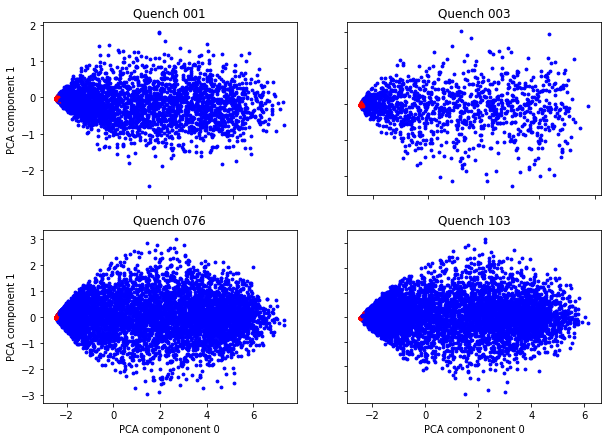

In [16]:
# Plot the PCA to see which clustering a point is correspond to!
from mpl_toolkits.mplot3d import Axes3D

msize = 8

fig, axs = plt.subplots(2, 2)
# fig = plt.figure()
# axs = fig.add_subplot(111, projection='3d')
fig.set_size_inches(10,7)
for i in range(qall_data.shape[0]):
    if color_label[i] == 'red':
        if clustering.labels_[i] == 0:
            axs[0, 0].scatter(img_pca[i,0],img_pca[i,1], color='r', s=msize)
        elif clustering.labels_[i] == -1:
            axs[0, 0].scatter(img_pca[i,0],img_pca[i,1], color='b', s=msize)
        else:
            axs[0, 0].scatter(img_pca[i,0],img_pca[i,1], color='g', s=msize)
        axs[0, 0].set_title('Quench 001')
    elif color_label[i] == 'orange':
        if clustering.labels_[i] == 0:
            axs[0, 1].scatter(img_pca[i,0],img_pca[i,1], color='r', s=msize)
        elif clustering.labels_[i] == -1:
            axs[0, 1].scatter(img_pca[i,0],img_pca[i,1], color='b', s=msize)
        else:
            axs[0, 1].scatter(img_pca[i,0],img_pca[i,1], color='g', s=msize)
        axs[0, 1].set_title('Quench 003')
    elif color_label[i] == 'green':
        if clustering.labels_[i] == 0:
            axs[1, 0].scatter(img_pca[i,0],img_pca[i,1], color='r', s=msize)
        elif clustering.labels_[i] == -1:
            axs[1, 0].scatter(img_pca[i,0],img_pca[i,1], color='b', s=msize)
        else:
            axs[1, 0].scatter(img_pca[i,0],img_pca[i,1], color='g', s=msize)
        axs[1, 0].set_title('Quench 076')
    else:
        if clustering.labels_[i] == 0:
            axs[1, 1].scatter(img_pca[i,0],img_pca[i,1], color='r', s=msize)
        elif clustering.labels_[i] == -1:
            axs[1, 1].scatter(img_pca[i,0],img_pca[i,1], color='b', s=msize)
        else:
            axs[1, 1].scatter(img_pca[i,0],img_pca[i,1], color='g', s=msize)
        axs[1, 1].set_title('Quench 103')

for ax in axs.flat:
    ax.set(xlabel='PCA compononent 0', ylabel='PCA component 1')

# axs.set_xlabel('PCA compononent 0')
# axs.set_ylabel('PCA compononent 1')
# axs.set_zlabel('PCA compononent 2')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

(5705, 2000, 1)
[3373, 12717, 3788]


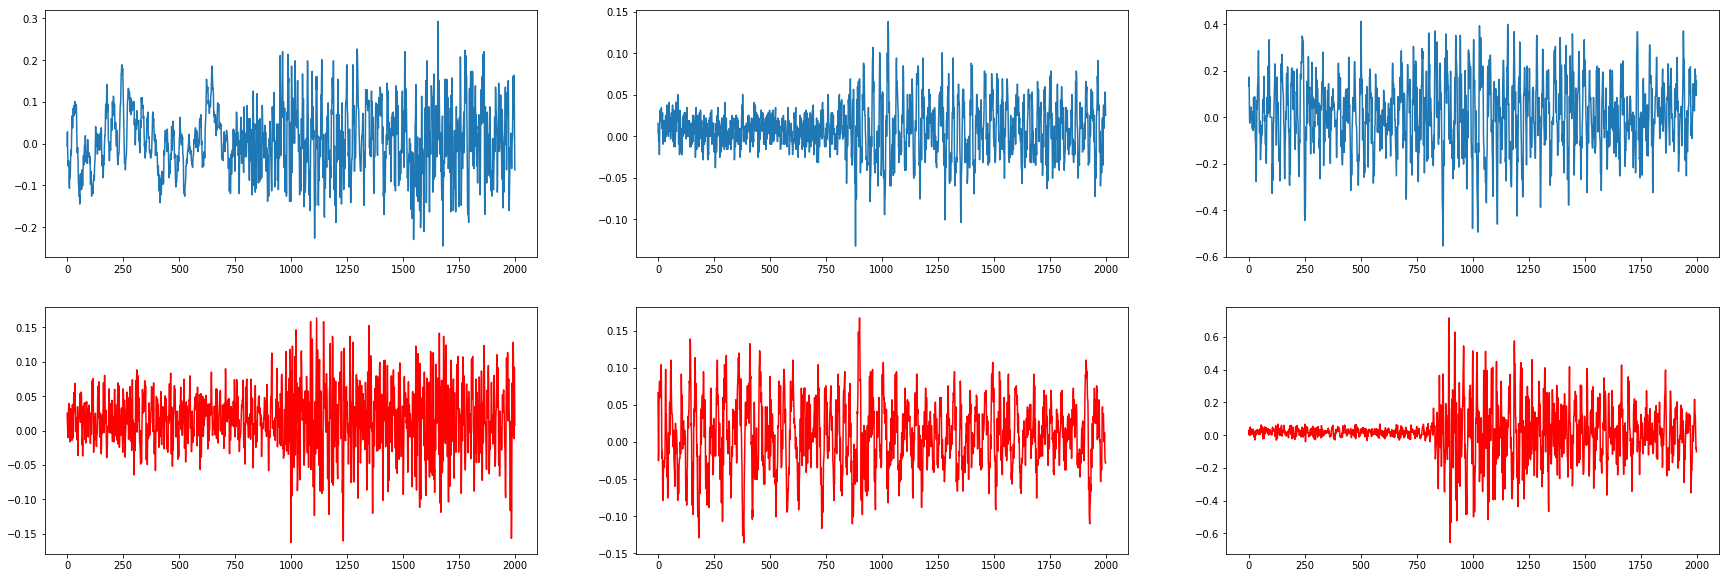

In [20]:
# Try to plot what class-1 and class31 correspond to
num_images = 3
class_minus = []
class_31 = []

for _ in range(qall_data.shape[0]):
    if len(class_minus) == num_images and len(class_31) == num_images:
        break
    
    random_image = np.random.randint(qall_data.shape[0], size = 1)
    if clustering.labels_[random_image[0]] == -1 and len(class_minus) < num_images:
        class_minus.append(random_image[0])
    elif clustering.labels_[random_image[0]] == 0 and len(class_31) < num_images:
        class_31.append(random_image[0])

# decoded_imgs = autoencoder.predict(data_mod)

print(x_test.shape)
# print(decoded_imgs.shape)
print(class_31)

plt.figure(figsize=(30, 10))
#scalograms are 256 by 512

for i in range(3):
    # plot original image
    ax = plt.subplot(2, num_images, i + 1)
    plt.plot(data_mod[class_minus[i], :, 0])
    # plt.plot(decoded_imgs[class_minus[i], :, 0])
    
    # plot encoded image
#     ax = plt.subplot(3, num_images, num_images + i + 1)
#     plt.imshow(encoded_imgs[image_idx, :, 256].reshape(8, 5))
#     plt.gray()
#     ax.get_xaxis().set_visible(False)
#     ax.get_yaxis().set_visible(False)
#     plt.axis('equal')

    ax = plt.subplot(2, num_images, num_images + i + 1)
    plt.plot(data_mod[class_31[i], :, 0], 'r')
    # plt.plot(decoded_imgs[class_31[i], :, 0])

plt.show()

In [21]:
#ok try TSNE for dimensionality reduction instead
from sklearn.manifold import TSNE

perplexity = 30

#if time permits try other complexities

tsne = TSNE(perplexity=perplexity, n_components=2, init='pca', n_iter=1000, random_state=2157)
q_tsne_array = tsne.fit_transform(encoded)

(22820, 2)


<Figure size 720x504 with 0 Axes>

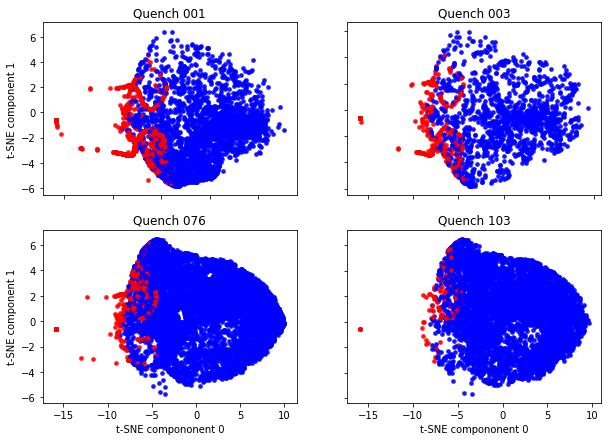

In [22]:
print(q_tsne_array.shape)

plt.figure(figsize=(10, 7))
lw=2
alpha=0.8
msize = 8

#to do this we need a quench_answers_array [0 to 3]
q001_ones = np.zeros(len(q001_data))
q003_ones = np.ones(len(q003_data))*1
q076_ones = np.ones(len(q076_data))*2
q103_ones = np.ones(len(q103_data))*3
q_answers_array = np.concatenate((q001_ones, q003_ones, q076_ones, q103_ones))
    
fig, axs = plt.subplots(2, 2)
# fig = plt.figure()
# axs = fig.add_subplot(111, projection='3d')
fig.set_size_inches(10,7)
for i in range(qall_data.shape[0]):
    if color_label[i] == 'red':
        if clustering.labels_[i] ==0:
            axs[0, 0].scatter(q_tsne_array[i,0],q_tsne_array[i,1], color='r', s=msize, lw=lw, alpha=alpha, label=q_answers_array)
        elif clustering.labels_[i] == -1:
            axs[0, 0].scatter(q_tsne_array[i,0],q_tsne_array[i,1], color='b', s=msize, lw=lw, alpha=alpha, label=q_answers_array)
        else:
            axs[0, 0].scatter(q_tsne_array[i,0],q_tsne_array[i,1], color='g', s=msize, lw=lw, alpha=alpha, label=q_answers_array)
        axs[0, 0].set_title('Quench 001')
    elif color_label[i] == 'orange':
        if clustering.labels_[i] == 0:
            axs[0, 1].scatter(q_tsne_array[i,0],q_tsne_array[i,1], color='r', s=msize, lw=lw, alpha=alpha, label=q_answers_array)
        elif clustering.labels_[i] == -1:
            axs[0, 1].scatter(q_tsne_array[i,0],q_tsne_array[i,1], color='b', s=msize, lw=lw, alpha=alpha, label=q_answers_array)
        else:
            axs[0, 1].scatter(q_tsne_array[i,0],q_tsne_array[i,1], color='g', s=msize, lw=lw, alpha=alpha, label=q_answers_array)
        axs[0, 1].set_title('Quench 003')
    elif color_label[i] == 'green':
        if clustering.labels_[i] == 0:
            axs[1, 0].scatter(q_tsne_array[i,0],q_tsne_array[i,1], color='r', s=msize, lw=lw, alpha=alpha, label=q_answers_array)
        elif clustering.labels_[i] == -1:
            axs[1, 0].scatter(q_tsne_array[i,0],q_tsne_array[i,1], color='b', s=msize, lw=lw, alpha=alpha, label=q_answers_array)
        else:
            axs[1, 0].scatter(q_tsne_array[i,0],q_tsne_array[i,1], color='g', s=msize, lw=lw, alpha=alpha, label=q_answers_array)
        axs[1, 0].set_title('Quench 076')
    else:
        if clustering.labels_[i] == 0:
            axs[1, 1].scatter(q_tsne_array[i,0],q_tsne_array[i,1], color='r', s=msize, lw=lw, alpha=alpha, label=q_answers_array)
        elif clustering.labels_[i] == -1:
            axs[1, 1].scatter(q_tsne_array[i,0],q_tsne_array[i,1], color='b', s=msize, lw=lw, alpha=alpha, label=q_answers_array)
        else:
            axs[1, 1].scatter(q_tsne_array[i,0],q_tsne_array[i,1], color='g', s=msize, lw=lw, alpha=alpha, label=q_answers_array)
        axs[1, 1].set_title('Quench 103')

for ax in axs.flat:
    ax.set(xlabel='t-SNE compononent 0', ylabel='t-SNE component 1')

# plt.legend(loc='best', shadow=False, scatterpoints=1)

# axs.set_xlabel('PCA compononent 0')
# axs.set_ylabel('PCA compononent 1')
# axs.set_zlabel('PCA compononent 2')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()